**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Intro to Random Forests

# May.3rd, 2020

Personal notes for the **fastai** course on machine learning 
- Random Forest classifier

The first thing is to mount my google drive and get the training dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import os

root = os.getcwd()
file = os.path.join(root, 'drive/My Drive/ML/Train.csv')

## Imports

Installing the fastai library (version 0.7)

In [0]:
!pip install fastai==0.7.0
# Any command followed by ! will be treated as a shell command

In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
from fastai.imports import *

from IPython.display import display

from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.impute import SimpleImputer as Imputer # fastai v0.7 uses a deprecated function from sklearn
from sklearn import metrics
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## The data

### Look at the data

Kaggle provides info about some of the fields of our dataset; on the [Kaggle Data info](https://www.kaggle.com/c/bluebook-for-bulldozers/data) page they say the following:

For this competition, you are predicting the sale price of bulldozers sold at auctions. The data for this competition is split into three parts:

- **Train.csv** is the training set, which contains data through the end of 2011.
- **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012. You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
- **Test.csv** is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

- SalesID: the unique identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale

*Question*

What stands out to you from the above description?  What needs to be true of our training and validation sets?

In [0]:
df_raw = pd.read_csv(file, low_memory=False, 
                     parse_dates=["saledate"])

# parse_dates argument will make the column values 'dates'

In any sort of data science work, it's **important to look at your data**, to make sure you understand the format, how it's stored, what type of values it holds, etc. Even if you've read descriptions about your data, the actual data may not be what you expect.

In [0]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [0]:
display_all(df_raw.tail().T)

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [0]:
display_all(df_raw.describe(include='all').T)

# Summarizing the data

It's important to note what metric is being used for a project. Generally, selecting the metric(s) is an important part of the project setup. However, in this case Kaggle tells us what metric to use: RMSLE (root mean squared log error) between the actual and predicted auction prices. Therefore we take the log of the prices, so that RMSE will give us what we need.

In [0]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

# The dependent variable - saleprice - is a continuous variable, meaning we are working with a regression problem

### Initial processing

In [0]:
m = RandomForestRegressor(n_jobs=-1)

# The following code is supposed to fail due to string values in the input data

m.fit(df_raw.drop('SalePrice', axis=1), df_raw.SalePrice)

ValueError: ignored

This dataset contains a mix of **continuous** and **categorical** variables.

The following method extracts particular date fields from a complete datetime for the purpose of constructing categoricals.  You should always consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities.

In [0]:
We will use the function 'add_datepart' to parse the date into separate columns containing numerical and boolean categorical values
This function is part of the fastai library

'''
>>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
>>> df
        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13
>>> add_datepart(df, 'A')
>>> df
        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False  
'''

In [0]:
def add_datepart(df, fldnames, drop=True, time=False, errors="raise"):	
    
    if isinstance(fldnames,str): 
        fldnames = [fldnames]
    for fldname in fldnames:
        fld = df[fldname]
        fld_dtype = fld.dtype
        if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
            fld_dtype = np.datetime64

        if not np.issubdtype(fld_dtype, np.datetime64):
            df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
        targ_pre = re.sub('[Dd]ate$', '', fldname)
        attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
        if time: attr = attr + ['Hour', 'Minute', 'Second']
        for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
        df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
        if drop: df.drop(fldname, axis=1, inplace=True)

In [0]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call `train_cats` to convert strings to pandas categories.

In [0]:
def train_cats(df):
    """Change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.
    Parameters:
    ---------
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category
    """
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [0]:
train_cats(df_raw)

In [0]:
df_raw.UsageBand

0            Low
1            Low
2           High
3           High
4         Medium
           ...  
401120       NaN
401121       NaN
401122       NaN
401123       NaN
401124       NaN
Name: UsageBand, Length: 401125, dtype: category
Categories (3, object): [High < Low < Medium]

We can specify the order to use for categorical variables if we wish:

In [0]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [0]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

Normally, pandas will continue displaying the text categories, while treating them as numerical data internally. Optionally, we can replace the text categories with numbers, which will make this variable non-categorical, like so:.

In [0]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

In [0]:
df_raw.UsageBand

0         2
1         2
2         0
3         0
4         1
         ..
401120   -1
401121   -1
401122   -1
401123   -1
401124   -1
Name: UsageBand, Length: 401125, dtype: int8

We're still not quite done - for instance we have lots of missing values, which we can't pass directly to a random forest.

In [0]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw)) # Displaying the fraction of NaN values for each column

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

But let's save this file for now, since it's already in format can we be stored and accessed efficiently.

In [0]:
root = os.getcwd()
df_raw.to_feather(os.path.join(root,'drive/My Drive/ML/bulldozers-raw'))

In [0]:
os.listdir(os.path.join(root,'drive/My Drive/ML/'))

['Train.csv', 'bulldozers-raw']

### Pre-processing

In the future we can simply read it from this fast format.

In [0]:
df_raw = pd.read_feather('tmp/bulldozers-raw')

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [0]:
def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    Parameters:
    -----------
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.
    Parameters:
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1    

def get_sample(df,n):
    """ Gets a random sample of n rows from df, without replacement.
    """
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()
    
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe. For each column of df 
    which is not in skip_flds nor in ignore_flds, na values are replaced by the
    median value of the column.
    Parameters:
    -----------
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [0]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [0]:
nas

{'MachineHoursCurrentMeter': 0.0, 'auctioneerID': 2.0}

In [0]:
y # Log-transformed dependent variable (Saleprice)

array([11.09741002, 10.95080655,  9.21034037, ...,  9.35010231,
        9.10497986,  8.95544812])

We now have something we can pass to a random forest!


In statistics, the coefficient of determination, denoted R2 or r2 and pronounced "R squared", is the proportion of the variance in the dependent variable that is predictable from the independent variable(s). https://en.wikipedia.org/wiki/Coefficient_of_determination

Wow, an r^2 of 0.98 - that's great, right? Well, perhaps not...

Possibly **the most important idea** in machine learning is that of having separate training & validation data sets. As motivation, suppose you don't divide up your data, but instead use all of it.  And suppose you have lots of parameters:

<img src="https://github.com/fastai/fastai/blob/master/courses/ml1/images/overfitting2.png?raw=1" alt="" style="width: 70%"/>
<center>
[Underfitting and Overfitting](https://datascience.stackexchange.com/questions/361/when-is-a-model-underfitted)
</center>

The error for the pictured data points is lowest for the model on the far right (the blue curve passes through the red points almost perfectly), yet it's not the best choice.  Why is that?  If you were to gather some new data points, they most likely would not be on that curve in the graph on the right, but would be closer to the curve in the middle graph.

This illustrates how using all our data can lead to **overfitting**. A validation set helps diagnose this problem.

In [0]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

# Random Forests

#The basics of Random Forest:

- If the dependent variable is numerical, then it is a regressor. Each feature and observation is tested for a binary split and the split that gives the lowest within group variance in resulting groups is chosen (weighted MSE). It is an ANOVA

- For the resulting two groups after a split, features other than the one used for this split are tested for the lowest MSEs. Repeat this multiple times until the maximum tree depth is reached (it can be provided or until the lowest variances are reached). In the end, the goal is to divide the dependent variable into multiple groups that give the lowest within-group variances. 

- If the dependent variable is categorical, then it is a classification problem. Thus, gini index or information gain can be used instead to assess how good the splits are

- Each random forest model will be a collection of many different trees (via boostrapping), prediction is made on each individual tree and the resulting predictions are averaged. This will lower the error since we will be dividing the MSEs by 'n' number of trees. For categorial dependent variables, major votes from the individual trees are used. 


## Base model

Let's try our model again, this time with separate training and validation sets.

In [0]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [0]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

# This takes ~10 - 15 minutes !

An r^2 in the high-80's isn't bad at all (and the RMSLE puts us around rank 100 of 470 on the Kaggle leaderboard), but we can see from the validation set score that we're over-fitting badly. To understand this issue, let's simplify things down to a single small tree.

## Speeding things up

In [0]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [0]:
print(X_train.shape, y_train.shape)

(20000, 66) (20000,)


In [0]:
m = RandomForestRegressor(n_jobs=-1) # n_jobs = # of cores
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 36.6 s, sys: 73.9 ms, total: 36.7 s
Wall time: 18.8 s
[0.09271393214596492, 0.3457522053769219, 0.9812282053713642, 0.7865098256708917]


## Single tree

In [0]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5283212494445121, 0.581089677208719, 0.39044633009402296, 0.39697641965162084]


Single tree gives us a very poor result as expected

In [0]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.
    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

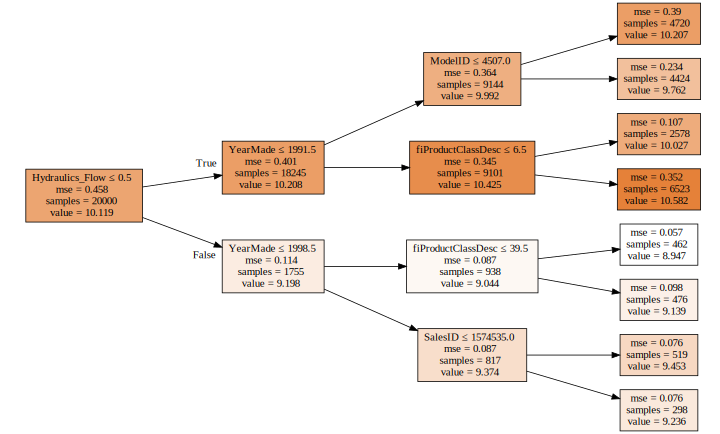

In [0]:
draw_tree(m.estimators_[0], df_trn, precision=3) # value = mean value

Let's see what happens if we create a bigger tree.

In [0]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[3.7682219008410604e-17, 0.4711591602613224, 1.0, 0.6035547195018107]


The training set result looks great! But the validation set is worse than our original model. This is why we need to use *bagging* of multiple trees to get more generalizable results.

## Bagging

### Intro to bagging

To learn about bagging in random forests, let's start with our basic model again.

In [0]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.0928082653520457, 0.34816789217072586, 0.981189986639923, 0.7835161960667695]


In [0]:
m.estimators_ # individual trees
m.estimators_[0]

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1103637012, splitter='best')

We'll grab the predictions for each individual tree, and look at one example.

In [0]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([ 9.68034,  9.04782,  9.04782,  8.92266,  9.10498,  8.9872 ,  9.04782,  9.15905,  9.10498,  9.4727 ,
         8.92266,  9.10498,  9.39266,  9.04782,  9.68034,  8.92266,  9.4727 ,  9.21034,  9.9988 ,  8.92266,
         9.10498,  9.90349,  9.10498,  9.45329,  8.92266,  9.21034,  9.4727 ,  9.4727 ,  9.10498,  9.10498,
         9.04782,  9.10498,  9.54681,  8.92266,  9.68034,  9.43348,  9.68034,  9.10498,  8.92266,  9.10498,
         9.61581,  9.21034,  9.04782,  9.4727 ,  9.32812,  8.9872 ,  9.10498,  9.68034,  9.68034,  8.92266,
         9.68034,  9.10498,  9.61581,  9.04782,  9.04782,  8.92266,  9.51044,  9.10498,  9.54681,  9.04782,
         9.32812,  9.79813,  9.3501 ,  9.04782,  9.04782, 10.12663,  9.32812,  9.04782,  9.10498,  9.4727 ,
         9.25913,  9.25913,  8.92266,  9.25913,  9.32812,  9.32812,  9.85219,  9.10498,  9.04782,  9.21034,
         8.92266,  9.39266,  9.68034,  9.68034,  9.10498,  9.39266, 10.37349,  8.92266,  9.10498,  9.68034,
         9.21034,  9.25913, 

In [0]:
preds.shape # 100 trees

(100, 12000)

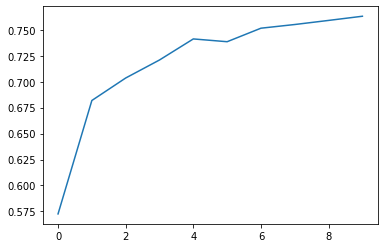

In [0]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

The shape of this curve suggests that adding more trees isn't going to help us much. Let's check. (Compare this to our original model on a sample)

In [0]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.1012579262689665, 0.3491392596862739, 0.9776089813919515, 0.7823065573766566]


In [0]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09548500426977446, 0.3515643518471606, 0.9800893179738536, 0.779271893621432]


In [0]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09282558586518155, 0.34191875818090584, 0.9811829650781325, 0.7912176272078502]


### Out-of-bag (OOB) score

Is our validation set worse than our training set because we're over-fitting, or because the validation set is for a different time period, or a bit of both? With the existing information we've shown, we can't tell. However, random forests have a very clever trick called *out-of-bag (OOB) error* which can handle this (and more!)

The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was *not* included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.

This also has the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

This is as simple as adding one more parameter to our model constructor. We print the OOB error last in our `print_score` function below.

Personal note: OOB puts aside X samples that are not used in each tree and test these samples on the trees that did not use these for its own construction. Mean accuracy is then calculated. 

In [0]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.09709738504863678, 0.34708771130837257, 0.9794112082439858, 0.7848573818783053, 0.8555607424910663]


This shows that our validation set time difference is making an impact, as is model over-fitting.

## Reducing over-fitting

### Subsampling

It turns out that one of the easiest ways to avoid over-fitting is also one of the best ways to speed up analysis: *subsampling*. Let's return to using our full dataset, so that we can demonstrate the impact of this technique.

In [0]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

The basic idea is this: rather than limit the total amount of data that our model can access, let's instead limit it to a *different* random subset per tree. That way, given enough trees, the model can still see *all* the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before.

In [0]:
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

In [0]:
set_rf_samples(20000)

In [0]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 15min 1s, sys: 1.58 s, total: 15min 3s
Wall time: 7min 44s
[0.07577605784967242, 0.2351802981346132, 0.9879995137977923, 0.9012243611718844, 0.9129648409973148]


In [0]:
len(m.estimators_)

100

Since each additional tree allows the model to see more data, this approach can make additional trees more useful.

In [0]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07841316587405775, 0.23620108284745525, 0.9871497137165048, 0.9003650418919334, 0.9084109941443484]


### Tree building parameters

We revert to using a full bootstrap sample in order to show the impact of other over-fitting avoidance methods.

In [0]:
def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [0]:
reset_rf_samples() # So RF is not re-sampling everytime it is constructing a tree

Let's get a baseline for this full set to compare to.

In [0]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

In [0]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[0.0785589643329006, 0.23632869525576683, 0.9871018826228223, 0.900257353210086, 0.9079858540279574]


In [0]:
t=m.estimators_[0].tree_

In [0]:
dectree_max_depth(t)

45

In [0]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1406261335884113, 0.2335866191713115, 0.9586698578745447, 0.9025585145745622, 0.9071587907937563]


In [0]:
t=m.estimators_[0].tree_

In [0]:
dectree_max_depth(t)

38

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf`) that we require some minimum number of rows in every leaf node. This has two benefits:

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [0]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11512837078569561, 0.2346780847912812, 0.9722987387037229, 0.9016457695842738, 0.9083052660676242]


We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree, but to also using a sample of *columns* for each *split*. We do this by specifying `max_features`, which is the proportion of features to randomly select from at each split.

- None
- 0.5
- 'sqrt'

- 1, 3, 5, 10, 25, 100

In [0]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11913435300623822, 0.22789711087041176, 0.9703374251384458, 0.9072475023837474, 0.9117144953284356]


We can't compare our results directly with the Kaggle competition, since it used a different validation set (and we can no longer to submit to this competition) - but we can at least see that we're getting similar results to the winners based on the dataset we have.

The sklearn docs [show an example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) of different `max_features` methods with increasing numbers of trees - as you see, using a subset of features on each split requires using more trees, but results in better models:
![sklearn max_features chart](http://scikit-learn.org/stable/_images/sphx_glr_plot_ensemble_oob_001.png)